<a href="https://colab.research.google.com/github/AlekaMelese/Atelectasis-Detection-in-Chest-X-ray-images/blob/main/Breast_Cancer_before_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import random
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from skimage.feature import hog # for feature extraction
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image as kimage
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
Atelectasis_dir = "/content/drive/MyDrive/MRI/Sick/"
normal_dir = "/content/drive/MyDrive/MRI/Healthy/"

(250, 540)


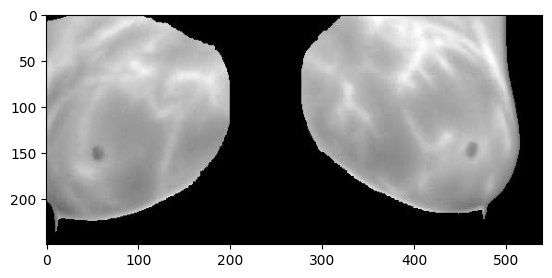

In [5]:
path = normal_dir + os.listdir(normal_dir)[10]
img = mpimg.imread(path)
print(img.shape)
plt.imshow(img, cmap='gray')

(250, 540)
(224, 224)


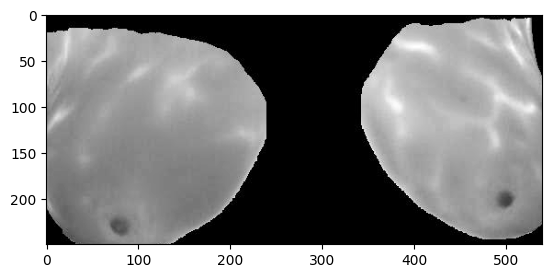

In [6]:
path = normal_dir + os.listdir(normal_dir)[0]
img = mpimg.imread(path)
plt.imshow(img, cmap='gray')
print(img.shape)
resized_img = cv2.resize(img, (224,224))
print(resized_img.shape)




740


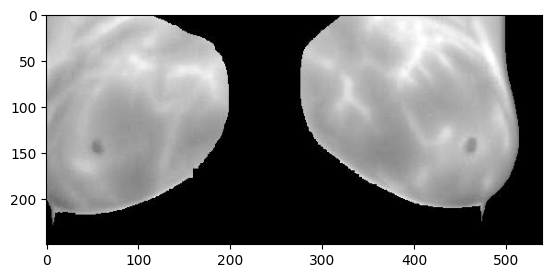

In [7]:
print(len(os.listdir(normal_dir)))
for image in range(10):
    path=normal_dir+os.listdir(normal_dir)[image]
    img = mpimg.imread(path)
    plt.imshow(img, cmap='gray')

740


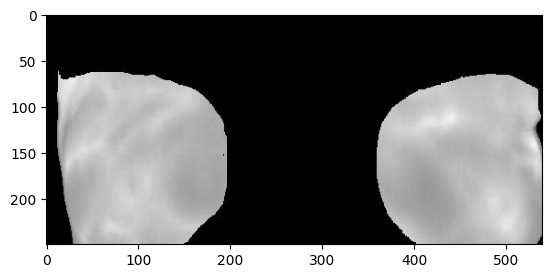

In [8]:
print(len(os.listdir(Atelectasis_dir)))
for image in range(10):
    path=Atelectasis_dir+os.listdir(Atelectasis_dir)[image]
    img = mpimg.imread(path)
    plt.imshow(img, cmap='gray')

In [9]:
path = normal_dir + os.listdir(normal_dir)[0]
img = cv2.imread(path)
resized_img = cv2.resize(img, (224,224))
print(resized_img.shape)

(224, 224, 3)


In [10]:
path = Atelectasis_dir + os.listdir(Atelectasis_dir)[0]
img = cv2.imread(path)
resized_img = cv2.resize(img, (224,224))
print(resized_img.shape)

(224, 224, 3)


In [11]:
for image in range(len(os.listdir(Atelectasis_dir))):
    path = Atelectasis_dir+os.listdir(Atelectasis_dir)[image]
    img = cv2.imread(path)
    resized_image = cv2.resize(img, (224,224))
    cv2.imwrite('Sick {}.jpg'.format(image), resized_image)

In [12]:
for image in range(len(os.listdir(normal_dir))):
    path = normal_dir+os.listdir(normal_dir)[image]
    img = cv2.imread(path)
    resized_image = cv2.resize(img, (224,224))
    cv2.imwrite('Normal {}.jpg'.format(image), resized_image)

In [13]:
os.mkdir("/content/drive/MyDrive/MRI/resized")

In [14]:
os.getcwd()

'/content'

In [15]:
d = os.listdir(os.getcwd())
for i in d:
    if os.path.isdir(i):
        print(i)

.config
drive
sample_data


In [16]:
os.mkdir('/content/drive/MyDrive/MRI/resized/Normal')
os.mkdir('/content/drive/MyDrive/MRI/resized/Sick')

In [20]:
for file in os.listdir(os.getcwd()):
    if file.split(' ')[0] == 'Normal':
        dest = shutil.move(file, '/content/drive/MyDrive/MRI/resized/Normal')
    elif file.split(' ')[0] == 'Sick':
        dest = shutil.move(file, '/content/drive/MyDrive/MRI/resized/Sick')
    else:
        dest = ""

# splitting data

In [21]:

root_dir = '/content/drive/MyDrive/MRI/resized/'
totalimages=0;
cls="Sick"
src = root_dir + cls # Folder to copy images from
AtelectasisFileNames = os.listdir(src)
print("Sick images:",len(AtelectasisFileNames))
totalimages=totalimages+len(AtelectasisFileNames)

root_dir = '/content/drive/MyDrive/MRI/resized/'
cls="Normal"
src = root_dir + cls # Folder to copy images from
normalFileNames = os.listdir(src)
print("Normal Images:",len(normalFileNames))
totalimages=totalimages+len(normalFileNames)

print("Total Images:",totalimages)

Sick images: 740
Normal Images: 740
Total Images: 1480


In [23]:
# # Creating Train / Val / Test folders (One time use)

root_dir = '/content/drive/MyDrive/MRI/resized/' # data root path
classes_dir = [ 'Normal', 'Sick'] #total labels

test_ratio = 0.20
val_ratio = 0.0

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'vald/' + cls)
    os.makedirs(root_dir +'test/' + cls)



totalimage=0
testimage=0
valimage=0
trainimage=0
sys.stdout.write("Spliting")
sys.stdout.write("    ")
for cls in classes_dir:
    # Creating partitions of the data after shuffeling
    src = root_dir + cls # Folder to copy images from
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                      [int(len(allFileNames)* (1 - (val_ratio + test_ratio))),
                                                       int(len(allFileNames)* (1 - test_ratio))])
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
    totalimage=totalimage+len(allFileNames)
    trainimage=trainimage+len(train_FileNames)
    valimage=valimage+ len(val_FileNames)
    testimage=testimage+len(test_FileNames)

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'train/' + cls)
        sys.stdout.write(".")
    for name in val_FileNames:
        shutil.copy(name, root_dir +'vald/' + cls)
        sys.stdout.write(".")
    for name in test_FileNames:
        shutil.copy(name, root_dir +'test/' + cls)
        sys.stdout.write(".")


print("")
print('Total images: ', totalimage)
print('Training: ',trainimage)
print('Validation: ', valimage)
print('Testing: ', testimage)

Spliting    ............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# CNN

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
import os
from PIL import Image
import seaborn as sns
SIZE=224

In [119]:
train_images = []
train_labels = []
for directory_path in glob.glob('/content/drive/MyDrive/MRI/resized/train/*'):
    label = directory_path.split("/")[-1]
   # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        train_images.append(img)
        train_labels.append(label)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [120]:
# test
test_images = []
test_labels = []
for directory_path in glob.glob('/content/drive/MyDrive/MRI/resized/test/*'):
    fruit_label = directory_path.split("/")[-1]
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        test_images.append(img)
        test_labels.append(fruit_label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [121]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
#le.fit(valid_labels)
#valid_label_encoded = le.transform(valid_labels)

In [122]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
from sklearn.model_selection import train_test_split
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [123]:
# Normalize pixel values to between 0 and 1
#x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [124]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train,2)
y_test_one_hot = to_categorical(y_test,2)

In [115]:
from sklearn.model_selection import train_test_split
x_train,x_valid,train_label,valid_label = train_test_split(x_train, y_train_one_hot, test_size=0.1, random_state=5)

In [34]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
#print('x_valid shape:', x_valid.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#print(x_valid.shape[0], 'test samples')

x_train shape: (1065, 224, 224)
x_test shape: (296, 224, 224)
1065 train samples
296 test samples


In [35]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [36]:
# Find the unique numbers from the train labels
classes = np.unique(test_labels)
nClasses = len(classes)
print('Total number of7outputs : ', nClasses)
print('Output classes : ', classes)

Total number of7outputs :  2
Output classes :  ['Normal' 'Sick']


In [37]:
x_train.shape,x_valid.shape,train_label.shape,valid_label.shape

((1065, 224, 224), (119, 224, 224), (1065, 2), (119, 2))

In [125]:
SIZE=224
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', strides=2,  padding = 'same', input_shape = (SIZE, SIZE,1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.3))
#model.add(BatchNormalization())

#model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))
#model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.15))
#model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.15))
#model.add(BatchNormalization())
model.add(Flatten())
#model.add(Dense(1))
#model.add(Activation('sigmoid'))
#model.add(Dense(256, activation = 'relu'))
#model.add(Dropout(rate = 0.3))

In [126]:
#Add layers for deep learning prediction
x = model.output
x = Dense(256, activation = 'relu')(x)
#model.add(Dropout(rate = 0.3))
prediction_layer = Dense(2, activation = 'sigmoid')(x)

In [127]:
# Make a new model combining both feature extractor and x
from tensorflow import keras
from tensorflow.keras import layers
opt = keras.optimizers.Adam(learning_rate=0.001)
cnn_model = Model(inputs=model.input, outputs=prediction_layer)
cnn_model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics = ['acc'])
print(cnn_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5_input (InputLayer  [(None, 224, 224, 1)]     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 56, 56, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 28, 28, 64)        0   

In [41]:
import datetime
start = datetime.datetime.now()
#Train the CNN model
history = cnn_model.fit(x_train, train_label, epochs=50,batch_size = 64, validation_data = (x_valid, valid_label))
end = datetime.datetime.now()
print("Total execution time is: ", end-start)

Epoch 1/50
17/17 [==============================] - 14s 140ms/step - loss: 0.6956 - acc: 0.5099 - val_loss: 0.6925 - val_acc: 0.6723
Epoch 2/50
17/17 [==============================] - 1s 38ms/step - loss: 0.6861 - acc: 0.5455 - val_loss: 0.6655 - val_acc: 0.5882
Epoch 3/50
17/17 [==============================] - 1s 40ms/step - loss: 0.6680 - acc: 0.5953 - val_loss: 0.6568 - val_acc: 0.6387
Epoch 4/50
17/17 [==============================] - 1s 38ms/step - loss: 0.6451 - acc: 0.6319 - val_loss: 0.6182 - val_acc: 0.6387
Epoch 5/50
17/17 [==============================] - 1s 40ms/step - loss: 0.5935 - acc: 0.6770 - val_loss: 0.5782 - val_acc: 0.6891
Epoch 6/50
17/17 [==============================] - 1s 38ms/step - loss: 0.5325 - acc: 0.7418 - val_loss: 0.5607 - val_acc: 0.7227
Epoch 7/50
17/17 [==============================] - 1s 38ms/step - loss: 0.4456 - acc: 0.7962 - val_loss: 0.4691 - val_acc: 0.8151
Epoch 8/50
17/17 [==============================] - 1s 38ms/step - loss: 0.3414 -

In [42]:
model.save("Breast cancer_Before_Processing_Final.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
#test_eval = feature_extractor.evaluate(x_test, y_test_one_hot, verbose=1)
score = cnn_model.evaluate(x_test, y_test_one_hot, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 0s 10ms/step - loss: 0.1198 - acc: 0.9797
Test loss: 0.11979498714208603
Test accuracy: 0.9797297120094299


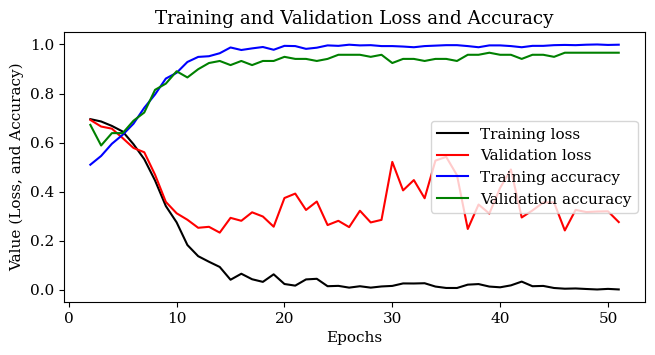

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
font = {'family': 'serif', 'size': 11}
plt.rc('font', **font)
# Extracting loss and accuracy values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(2, len(loss) + 2)
# Plotting the loss and accuracy values in one graph
plt.figure(figsize=(7.5, 3.5))
plt.plot(epochs, loss, 'black', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title(r'Training and Validation Loss and Accuracy', color='black')
plt.xlabel(r'Epochs', color='black')
plt.ylabel(r'Value (Loss, and Accuracy)', color='black')
plt.legend()
plt.show()

In [58]:
#test_eval = feature_extractor.evaluate(x_test, y_test_one_hot, verbose=1)
score = cnn_model.evaluate(x_train, train_label, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

34/34 [==============================] - 1s 19ms/step - loss: 0.0013 - acc: 1.0000
Train loss: 0.001331664388999343
Train accuracy: 1.0


In [59]:
#Validation
score = cnn_model.evaluate(x_valid, valid_label, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

4/4 [==============================] - 0s 126ms/step - loss: 0.2760 - acc: 0.9664
Validation loss: 0.27599918842315674
Validation accuracy: 0.9663865566253662


In [60]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=1)
prediction_NN = le.inverse_transform(prediction_NN)

10/10 [==============================] - 0s 7ms/step


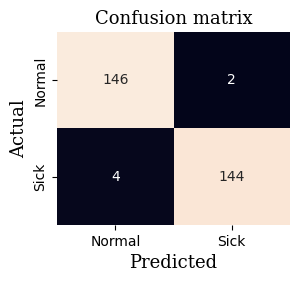

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Define font family and fontsize
font = {'family': 'serif',  'size': 13}
#font = {'family': 'serif', 'weight': 'bold', 'size': 14}
# Classes
nClasses = ['Normal','Sick']
# Confusion Matrix
plt.figure(figsize=(3, 2.5))
cm = confusion_matrix(test_labels, prediction_NN)
sns.heatmap(cm, cbar=False, xticklabels=nClasses, yticklabels=nClasses, fmt='d', annot=True)
plt.title('Confusion matrix', fontdict=font)
plt.xlabel(r'Predicted', fontdict=font)
plt.ylabel(r'Actual', fontdict=font)
plt.show()

In [62]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
#plt.title('Classification Report Before Image Preprocessing')
print(classification_report(test_labels, prediction_NN, target_names=['Normal  (Class 0)','Sick (Class 1)']))

                   precision    recall  f1-score   support

Normal  (Class 0)       0.97      0.99      0.98       148
   Sick (Class 1)       0.99      0.97      0.98       148

         accuracy                           0.98       296
        macro avg       0.98      0.98      0.98       296
     weighted avg       0.98      0.98      0.98       296



In [63]:
predicted_classes = cnn_model.predict(x_test)

10/10 [==============================] - 0s 10ms/step


In [64]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, y_test.shape

((296,), (296,))

Found 290 correct labels


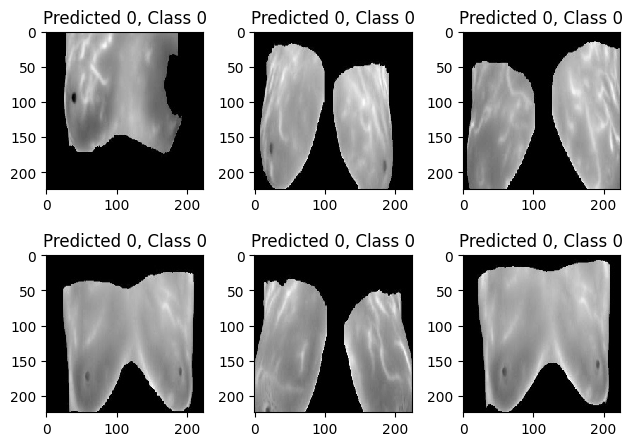

In [65]:
correct = np.where(predicted_classes==y_test)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[correct], cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()

Found 6 incorrect labels


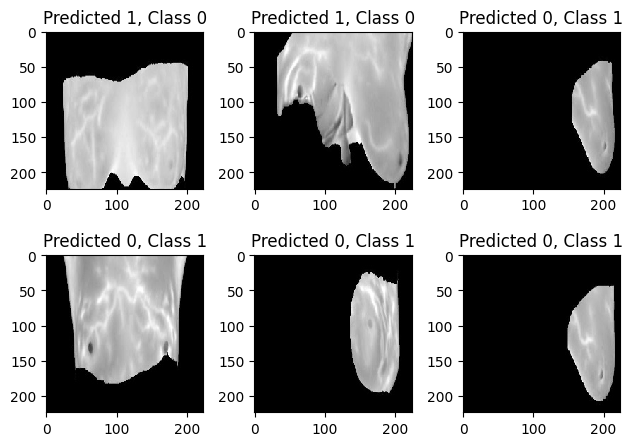

In [66]:
incorrect = np.where(predicted_classes!=y_test)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[incorrect], cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()

1/1 [==============================] - 0s 317ms/step
The prediction for this image is:  ['Normal']
The actual label for this image is:  Normal


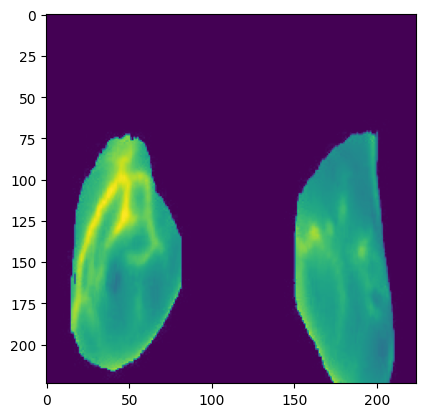

In [67]:
#Check results on a few select images
n=19  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(cnn_model.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

# Features from convolutional network for RF and SVM

In [130]:
#Now, let us use features from convolutional network for RF
X_for_RF = model.predict(x_train) #This is out X input to RF

37/37 [==============================] - 0s 4ms/step


# RANDOM FOREST

In [131]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [132]:
# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [133]:
#Send test data through same feature extractor process
X_test_feature = model.predict(x_test)
#Now predict using the trained RF model.
prediction_RF = RF_model.predict(X_test_feature)
#Inverse le transform to get original label back.
prediction_RF = le.inverse_transform(prediction_RF)

10/10 [==============================] - 0s 5ms/step


In [134]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.9324324324324325


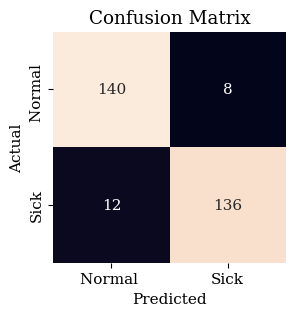

In [136]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal ', 'Sick']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_RF)
plt.title('Confusion Matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [137]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
#plt.title('Classification Report Before Image Preprocessing')
print(classification_report(test_labels, prediction_NN, target_names=['Normal  (Class 0)','Sick (Class 1)']))

                   precision    recall  f1-score   support

Normal  (Class 0)       0.97      0.99      0.98       148
   Sick (Class 1)       0.99      0.97      0.98       148

         accuracy                           0.98       296
        macro avg       0.98      0.98      0.98       296
     weighted avg       0.98      0.98      0.98       296



# SVM with CNN

# 1. Linear SVM

In [138]:
from sklearn.svm import  SVC
from sklearn.svm import LinearSVC
svclassifier = SVC(kernel='linear', degree=8)
#model = LinearSVC(max_iter=100)  #Default of 100 is not converging

In [139]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', degree=8)
svclassifier.fit(X_for_RF, y_train)

SVC(degree=8, kernel='linear')

In [140]:
X_test_feature = model.predict(x_test)
prediction_SVC = svclassifier.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)

10/10 [==============================] - 0s 4ms/step


In [141]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.6925675675675675


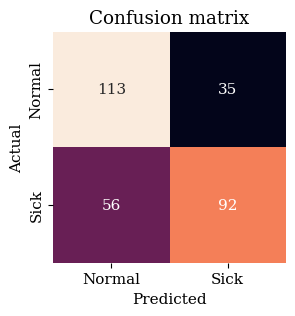

In [142]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sick']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [143]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
#plt.title('Classification Report Before Image Preprocessing')
print(classification_report(test_labels, prediction_NN, target_names=['Normal  (Class 0)','Sick (Class 1)']))

                   precision    recall  f1-score   support

Normal  (Class 0)       0.97      0.99      0.98       148
   Sick (Class 1)       0.99      0.97      0.98       148

         accuracy                           0.98       296
        macro avg       0.98      0.98      0.98       296
     weighted avg       0.98      0.98      0.98       296



# 2. Gaussian Kernel- rbf

In [144]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', degree=8)
svclassifier.fit(X_for_RF, y_train)

SVC(degree=8)

In [145]:
prediction_SVC = svclassifier.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)

In [146]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.8243243243243243


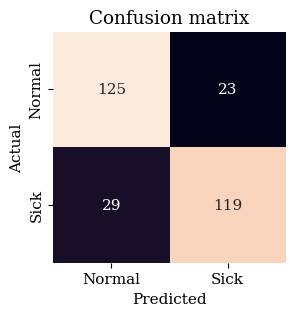

In [147]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sick']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [148]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
#plt.title('Classification Report Before Image Preprocessing')
print(classification_report(test_labels, prediction_NN, target_names=['Normal  (Class 0)','Sick (Class 1)']))

                   precision    recall  f1-score   support

Normal  (Class 0)       0.97      0.99      0.98       148
   Sick (Class 1)       0.99      0.97      0.98       148

         accuracy                           0.98       296
        macro avg       0.98      0.98      0.98       296
     weighted avg       0.98      0.98      0.98       296



# 3. Polynomial Kernel SVM

In [149]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_for_RF, y_train)

SVC(degree=8, kernel='poly')

In [150]:
prediction_SVC = svclassifier.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)

In [151]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.9493243243243243


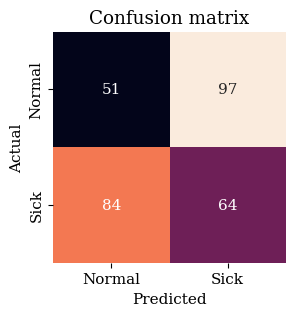

In [154]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sick']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [155]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
#plt.title('Classification Report Before Image Preprocessing')
print(classification_report(test_labels, prediction_NN, target_names=['Normal  (Class 0)','Sick (Class 1)']))

                   precision    recall  f1-score   support

Normal  (Class 0)       0.97      0.99      0.98       148
   Sick (Class 1)       0.99      0.97      0.98       148

         accuracy                           0.98       296
        macro avg       0.98      0.98      0.98       296
     weighted avg       0.98      0.98      0.98       296



# 4. Sigmoid

In [152]:
from sklearn.svm import SVC
svcmodel = SVC(kernel='sigmoid', degree=8)
svcmodel.fit(X_for_RF, y_train)

SVC(degree=8, kernel='sigmoid')

In [153]:
prediction_SVC = svcmodel.predict(X_test_feature)
prediction_SVC = le.inverse_transform(prediction_SVC)
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))


Accuracy =  0.3885135135135135


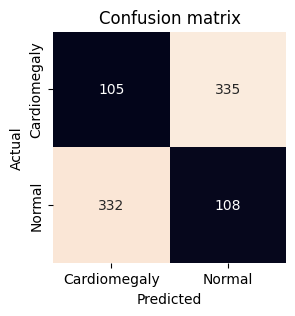

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Cardiomegaly', 'Normal']
plt.figure(figsize=(3,3))
cm = confusion_matrix(test_labels, prediction_SVC)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
#plt.title('Classification Report Before Image Preprocessing')
print(classification_report(test_labels, prediction_NN, target_names=['Cardiomegaly  (Class 0)','Normal (Class 1)']))

                         precision    recall  f1-score   support

Cardiomegaly  (Class 0)       1.00      0.99      0.99       440
       Normal (Class 1)       0.99      1.00      0.99       440

               accuracy                           0.99       880
              macro avg       0.99      0.99      0.99       880
           weighted avg       0.99      0.99      0.99       880



# HOG

In [ ]:

X_train =[] #for HOGs
Y_train = np.array([], dtype=float)  #for classes
X_test =[] #for HOGs
Y_test = np.array([], dtype=float)  #for classes

#specify your paths to images
covid_train_path = '/content/drive/MyDrive/Sarcoidosis/resized/train/Sarcoidosis'
normal_train_path = '/content/drive/MyDrive/Sarcoidosis/resized/train/Normal'
covid_test_path = '/content/drive/MyDrive/Sarcoidosis/resized/test/Sarcoidosis'
normal_test_path =  '/content/drive/MyDrive/Sarcoidosis/resized/test/Normal'
gamma =0.5

**feature extraction for training data**

In [ ]:
from skimage.feature import hog
# Read prepared images, extract HOG features and labeling samples 1 for covid and 0 for normal:
#Get normal features
for filename in glob.glob(os.path.join(normal_train_path, '*.jpg')):
    im = cv2.imread(filename, 0) # Your image goes here
#     im_neg = 255 - im
#     im_neg[im_neg >= 153] = 153 # Step #1
#     im_neg = im_neg + 102 # Step #2
#     # Apply log transform.
#     c = 255/(np.log(1 + np.max(im)))
#     log_transformed = c * np.log(1 + im)
#      # Apply gamma correction.
#     gamma_corrected = np.array(255*(im / 255) ** gamma, dtype = 'uint8')
    imag = np.float32(im)
    hist = hog(imag)
    X_train.append(hist)
    Y_train=np.append(Y_train,0)
    print(hist)
#Get covid fatures
for filename in glob.glob(os.path.join(covid_train_path, '*.jpg')):
    im = cv2.imread(filename, 0) # Your image goes here
#     im_neg = 255 - im
#     im_neg[im_neg >= 153] = 153 # Step #1
#     im_neg = im_neg + 102 # Step #2
#     # Apply log transform.
#     c = 255/(np.log(1 + np.max(im)))
#     log_transformed = c * np.log(1 + im)
#      # Apply gamma correction.
#     gamma_corrected = np.array(255*(im / 255) ** gamma, dtype = 'uint8')
    imag = np.float32(im)
    hist = hog(imag)
    X_train.append(hist)
    Y_train=np.append(Y_train,1)
    print(hist)



[0.01467967 0.         0.01384012 ... 0.00458618 0.0036257  0.08445761]
[0.26765096 0.08447172 0.04061902 ... 0.01691679 0.         0.        ]
[0.57379055 0.         0.00287155 ... 0.         0.         0.32545838]
[0.04226547 0.00350031 0.00221379 ... 0.         0.         0.2829124 ]
[0.         0.         0.         ... 0.06735282 0.03202723 0.04998306]
[0.03109065 0.00096557 0.00061068 ... 0.00100309 0.00255738 0.13456036]
[0.08191864 0.00145378 0.05903115 ... 0.         0.         0.        ]
[0.00989273 0.         0.00243312 ... 0.00778271 0.28934476 0.20544805]
[0.01967689 0.01135618 0.13843364 ... 0.11384828 0.00258203 0.26184377]
[0.         0.         0.         ... 0.19717285 0.21761844 0.03555616]
[0.12669933 0.03366664 0.01690396 ... 0.         0.01239631 0.33327198]
[0.         0.         0.         ... 0.         0.         0.12262087]
[0.00998477 0.00393999 0.00415312 ... 0.         0.         0.17531975]
[0.09114429 0.01698696 0.01125783 ... 0.         0.         0.02

<ipython-input-131-5f1d50256649>:2: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),


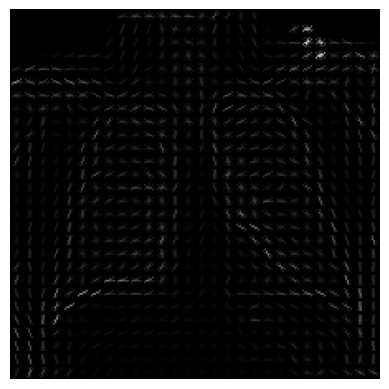

In [ ]:
#creating hog features
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")

feature extraction for testing data

In [ ]:
from skimage.feature import hog
# Read prepared images, extract HOG features and labeling samples 1 for covid and 0 for normal:

#Get covid fatures
for filename in glob.glob(os.path.join(covid_test_path, '*.jpg')):
    im = cv2.imread(filename, 0) # Your image goes here
#     im_neg = 255 - im
#     im_neg[im_neg >= 153] = 153 # Step #1
#     im_neg = im_neg + 102 # Step #2
#     # Apply log transform.
#     c = 255/(np.log(1 + np.max(im)))
#     log_transformed = c * np.log(1 + im)
#      # Apply gamma correction.
#     gamma_corrected = np.array(255*(im / 255) ** gamma, dtype = 'uint8')
    imag = np.float32(im)
    hist = hog(imag)
    X_test.append(hist)
    Y_test=np.append(Y_test,1)
    print(hist)

#Get normal features
for filename in glob.glob(os.path.join(normal_test_path, '*.jpg')):
    im = cv2.imread(filename, 0) # Your image goes here
#     im_neg = 255 - im
#     im_neg[im_neg >= 153] = 153 # Step #1
#     im_neg = im_neg + 102 # Step #2
#     # Apply log transform.
#     c = 255/(np.log(1 + np.max(im)))
#     log_transformed = c * np.log(1 + im)
#      # Apply gamma correction.
#     gamma_corrected = np.array(255*(im / 255) ** gamma, dtype = 'uint8')
    imag = np.float32(im)
    hist = hog(imag)
    X_test.append(hist)
    Y_test=np.append(Y_test,0)
    print(hist)

[0.07376682 0.03571339 0.05873976 ... 0.         0.         0.        ]
[0.00276867 0.00591389 0.02928561 ... 0.20158358 0.22544867 0.02368232]
[0.03478323 0.01576457 0.02843273 ... 0.00187054 0.         0.02010351]
[0.06587073 0.         0.         ... 0.02465055 0.01830028 0.24343647]
[0.03307926 0.         0.         ... 0.23281789 0.15730663 0.0708901 ]
[0.00070202 0.         0.         ... 0.00486403 0.         0.        ]
[0.         0.         0.         ... 0.01021275 0.00671904 0.00886638]
[0.15000719 0.         0.         ... 0.16238493 0.02962938 0.05446089]
[0.01242935 0.00994762 0.02550726 ... 0.04715189 0.02120784 0.00610228]
[0.00462215 0.         0.03297278 ... 0.00318225 0.00153976 0.01230832]
[0.08473656 0.02433763 0.04632648 ... 0.         0.         0.        ]
[0.01272736 0.         0.         ... 0.10334074 0.02908743 0.16073577]
[0.00351631 0.         0.00049728 ... 0.00462006 0.         0.00147582]
[0.00391589 0.00350248 0.00282379 ... 0.         0.0186139  0.26

<ipython-input-136-d727aea5e2b6>:2: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(2, 2),


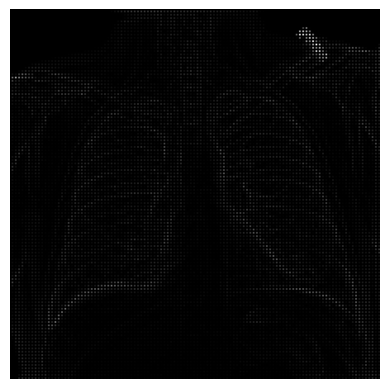

In [ ]:
#creating hog features
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(2, 2),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")

In [ ]:
# Note that images must has identical size. Otherwise you need to resize them inside for-loop or use sliding window technique (not covered in this note).
# Convert objects to Numpy float32 format:

X_train =np.float32(X_train)
Y_train = np.array(Y_train)
X_test =np.float32(X_test)
Y_test = np.array(Y_test)


In [ ]:
# Note that images must has identical size. Otherwise you need to resize them inside for-loop or use sliding window technique (not covered in this note).
# Convert objects to Numpy float32 format:

X_train =np.float32(X_train)
Y_train = np.array(Y_train)
X_test =np.float32(X_test)
Y_test = np.array(Y_test)


In [ ]:
print("X train",len(X_train))
print("Y_train",len(Y_train))

print("X_test",len(X_test))
print("Y_test",len(Y_test))

X train 960
Y_train 960
X_test 240
Y_test 240


In [ ]:
# Create SVM classifier from OpenCV library and set some properties:
# Train our SVM classifier and save it on hard disc. This may take time - it depends on images amount and size.

# svm.train(samples, cv.ml.ROW_SAMPLE, labels)
# svm.save('svm_data.dat')

svm= cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_RBF)
svm.setGamma(5.383)
svm.setC(30)
svm.setKernel(cv2.ml.SVM_LINEAR)
# svm.train(samples, cv.ml.ROW_SAMPLE, np.array(labels, dtype = np.int32))
svm.train(X_train, cv2.ml.ROW_SAMPLE, np.array(Y_train, dtype = np.int32))
svm.save('HOG_with_SVM_Threshold.dat')

In [ ]:
# Note that unclassified image must has exact size to images from training set. Otherwise you need to resize it before classification.
# Load previosly saved SVM classifier:

#load model from file system
svm = cv2.ml.SVM_load('HOG_with_SVM_Threshold.dat')

In [ ]:
# Classify our image:
y_pred = svm.predict(X_test)
y_pred=np.asarray(y_pred)
y_pred = np.delete(y_pred,0, 0)
y_pred =y_pred.flatten()
y_pred=y_pred[0].flatten()
y_pred=np.array(y_pred, dtype = np.int32)
print(len(y_pred))
print(len(np.array(Y_test, dtype = np.int32)))

240
240


<ipython-input-142-316b5b1c5534>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred=np.asarray(y_pred)


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy")
accuracy_score( np.array(Y_test, dtype = np.int32),y_pred)


Accuracy


0.9875

In [ ]:

cnf_matrix = confusion_matrix(Y_test, y_pred)
print(cnf_matrix)

[[200   0]
 [  3  37]]


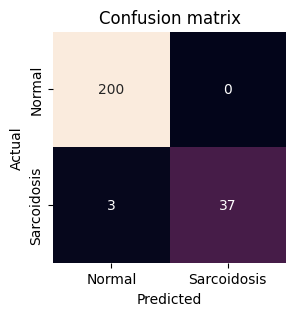

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(Y_test, y_pred)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(Y_test, y_pred, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.99      1.00      0.99       200
Sarcoidosis (Class 1)       1.00      0.93      0.96        40

             accuracy                           0.99       240
            macro avg       0.99      0.96      0.98       240
         weighted avg       0.99      0.99      0.99       240



#Linear

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', degree=8)
svclassifier.fit(X_train, Y_train)

SVC(degree=8, kernel='linear')

In [ ]:
y_pred = svclassifier.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy")
accuracy_score( np.array(Y_test, dtype = np.int32),y_pred)

Accuracy


0.9875

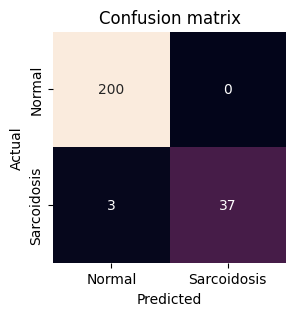

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(Y_test, y_pred)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(Y_test, y_pred, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.99      1.00      0.99       200
Sarcoidosis (Class 1)       1.00      0.93      0.96        40

             accuracy                           0.99       240
            macro avg       0.99      0.96      0.98       240
         weighted avg       0.99      0.99      0.99       240



# **`Gaussian Kernel- rbf`**

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', degree=8)
svclassifier.fit(X_train, Y_train)

SVC(degree=8)

In [ ]:
y_pred = svclassifier.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy")
accuracy_score( np.array(Y_test, dtype = np.int32),y_pred)


Accuracy


0.9791666666666666

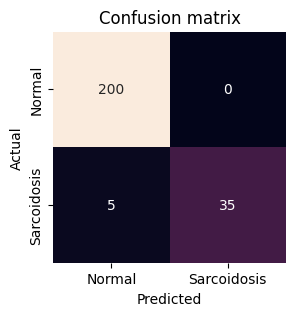

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(Y_test, y_pred)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(Y_test, y_pred, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.98      1.00      0.99       200
Sarcoidosis (Class 1)       1.00      0.88      0.93        40

             accuracy                           0.98       240
            macro avg       0.99      0.94      0.96       240
         weighted avg       0.98      0.98      0.98       240



#Sigmoid


In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid', degree=8)
svclassifier.fit(X_train, Y_train)

SVC(degree=8, kernel='sigmoid')

In [ ]:
y_pred = svclassifier.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy")
accuracy_score( np.array(Y_test, dtype = np.int32),y_pred)


Accuracy


0.9541666666666667

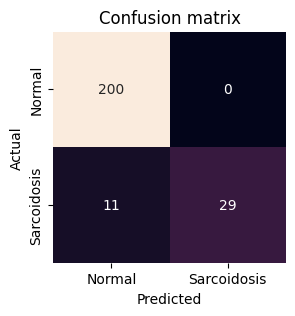

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(Y_test, y_pred)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(Y_test, y_pred, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.95      1.00      0.97       200
Sarcoidosis (Class 1)       1.00      0.72      0.84        40

             accuracy                           0.95       240
            macro avg       0.97      0.86      0.91       240
         weighted avg       0.96      0.95      0.95       240



# **Polynomial Kernel-ploy**

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_train, Y_train)

SVC(degree=8, kernel='poly')

In [ ]:
y_pred = svclassifier.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy")
accuracy_score( np.array(Y_test, dtype = np.int32),y_pred)


Accuracy


0.9458333333333333

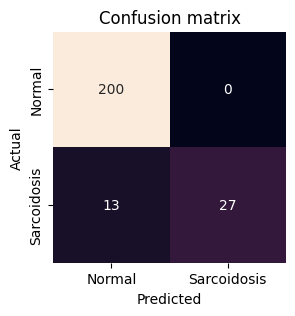

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
classes = ['Normal', 'Sarcoidosis']
plt.figure(figsize=(3,3))
cm = confusion_matrix(Y_test, y_pred)
plt.title('Confusion matrix')
#sns.heatmap(cm, annot=True)
#sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.Blues)
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(Y_test, y_pred, target_names=['Normal (Class 0)','Sarcoidosis (Class 1)']))

                       precision    recall  f1-score   support

     Normal (Class 0)       0.94      1.00      0.97       200
Sarcoidosis (Class 1)       1.00      0.68      0.81        40

             accuracy                           0.95       240
            macro avg       0.97      0.84      0.89       240
         weighted avg       0.95      0.95      0.94       240

